In [1]:
import os.path

import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
import mne_icalabel
import copy


C:\Users\ROG\miniconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def load(ok=False):
    def load_fif_file(file_path):
        raw = mne.io.read_raw_fif(file_path, preload=True)
        return raw
    file_path="C:/Users/ROG/Desktop/Pipeline"
    print(os.listdir(file_path))
    for file in os.listdir(file_path):
        if file.endswith(".fif"):
            raw = load_fif_file(os.path.join(file_path,file))
            if ok==True:
                for channel in raw.ch_names:
                    channel_data = raw.copy().pick_channels([channel]).get_data()
                    plt.figure()
                    plt.plot(channel_data[0])
                    plt.title(f'Channel: {channel}')
                    plt.show()
            return raw


In [103]:
from mne import Epochs


class pipeliune:
    def __init__(self, raw, fs=250, cutoff=1):
        self.raw = raw
        self.fs = fs
        self.cutoff = cutoff
    def butter_highpass_filter(self, order=5):
        filt_raw = self.raw.copy().filter(l_freq=1.0, h_freq=None)
        return filt_raw

    def notch_filter(self):
        data_highpass = self.butter_highpass_filter()
        filt_raw = data_highpass.copy().notch_filter([48, 52], picks="eeg", filter_length="auto", phase="zero", verbose=True)
        return filt_raw


    def IC_label(self):
        raw_notch_filtered = self.notch_filter()
        filt_raw = raw_notch_filtered.set_eeg_reference("average")

        ica = ICA(
            n_components=6,
            max_iter="auto",
            method="infomax",
            random_state=97,
            fit_params=dict(extended=True),
        )
        ica.fit(filt_raw)

        # Apply the ICA to the raw data
        raw_ica_applied = ica.apply(filt_raw.copy())

        ic_labels = mne_icalabel.label_components(raw_ica_applied, ica, method="iclabel")
        #Plot the ica components
        ica.plot_components()
        labels = ic_labels["labels"]
        exclude_idx = [
            idx for idx, label in enumerate(labels) if label not in ["brain", "other"]
        ]
        ica.exclude = exclude_idx
        raw_ica_applied = ica.apply(filt_raw.copy())
        return ica, raw_ica_applied
    def epoch(self):
        a,b=self.IC_label()
        source = a.get_sources(b)
        data = source.get_data()
        #Apply basdeline removal
        based_line=mne.baseline.rescale(data,b.times, baseline=(0,0.5))
        #Create epochs
        events = mne.make_fixed_length_events(b, id=1, duration=1.0)
        epochs = Epochs(b, events, tmin=0, tmax=1, baseline=(0, 0.5))
        return epochs


In [104]:

raw=load()
#raw.plot()
pip = pipeliune(raw)


['.git', '.idea', 'kms-raw.fif', 'ok.py', 'Pipeline.ipynb', 'pipeline.py', '__pycache__']


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



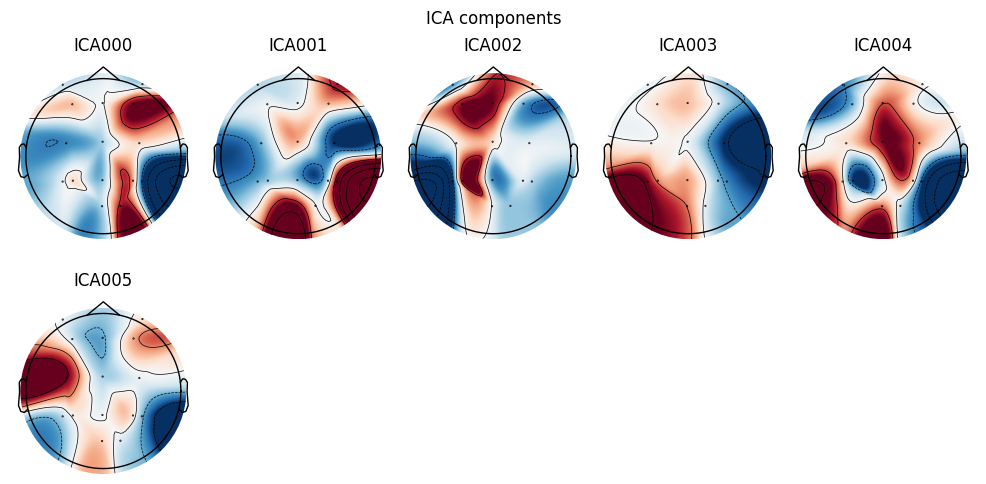

In [105]:
c=pip.epoch()

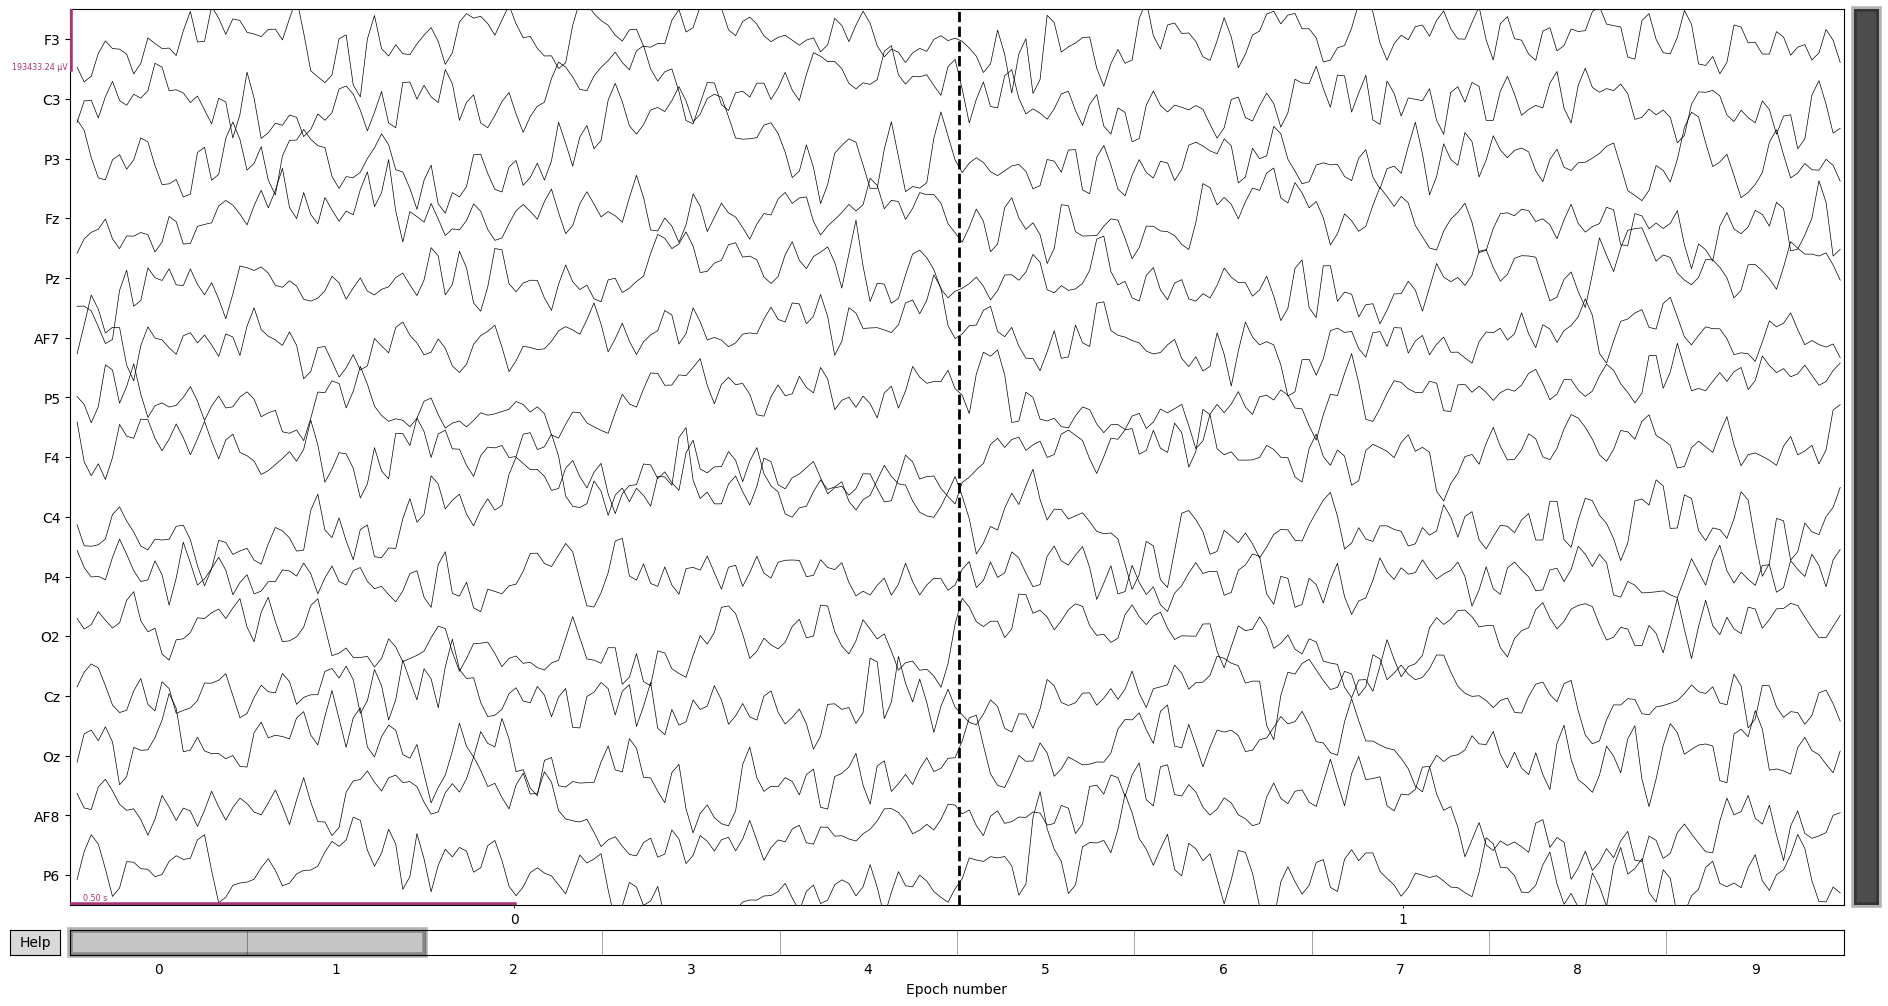

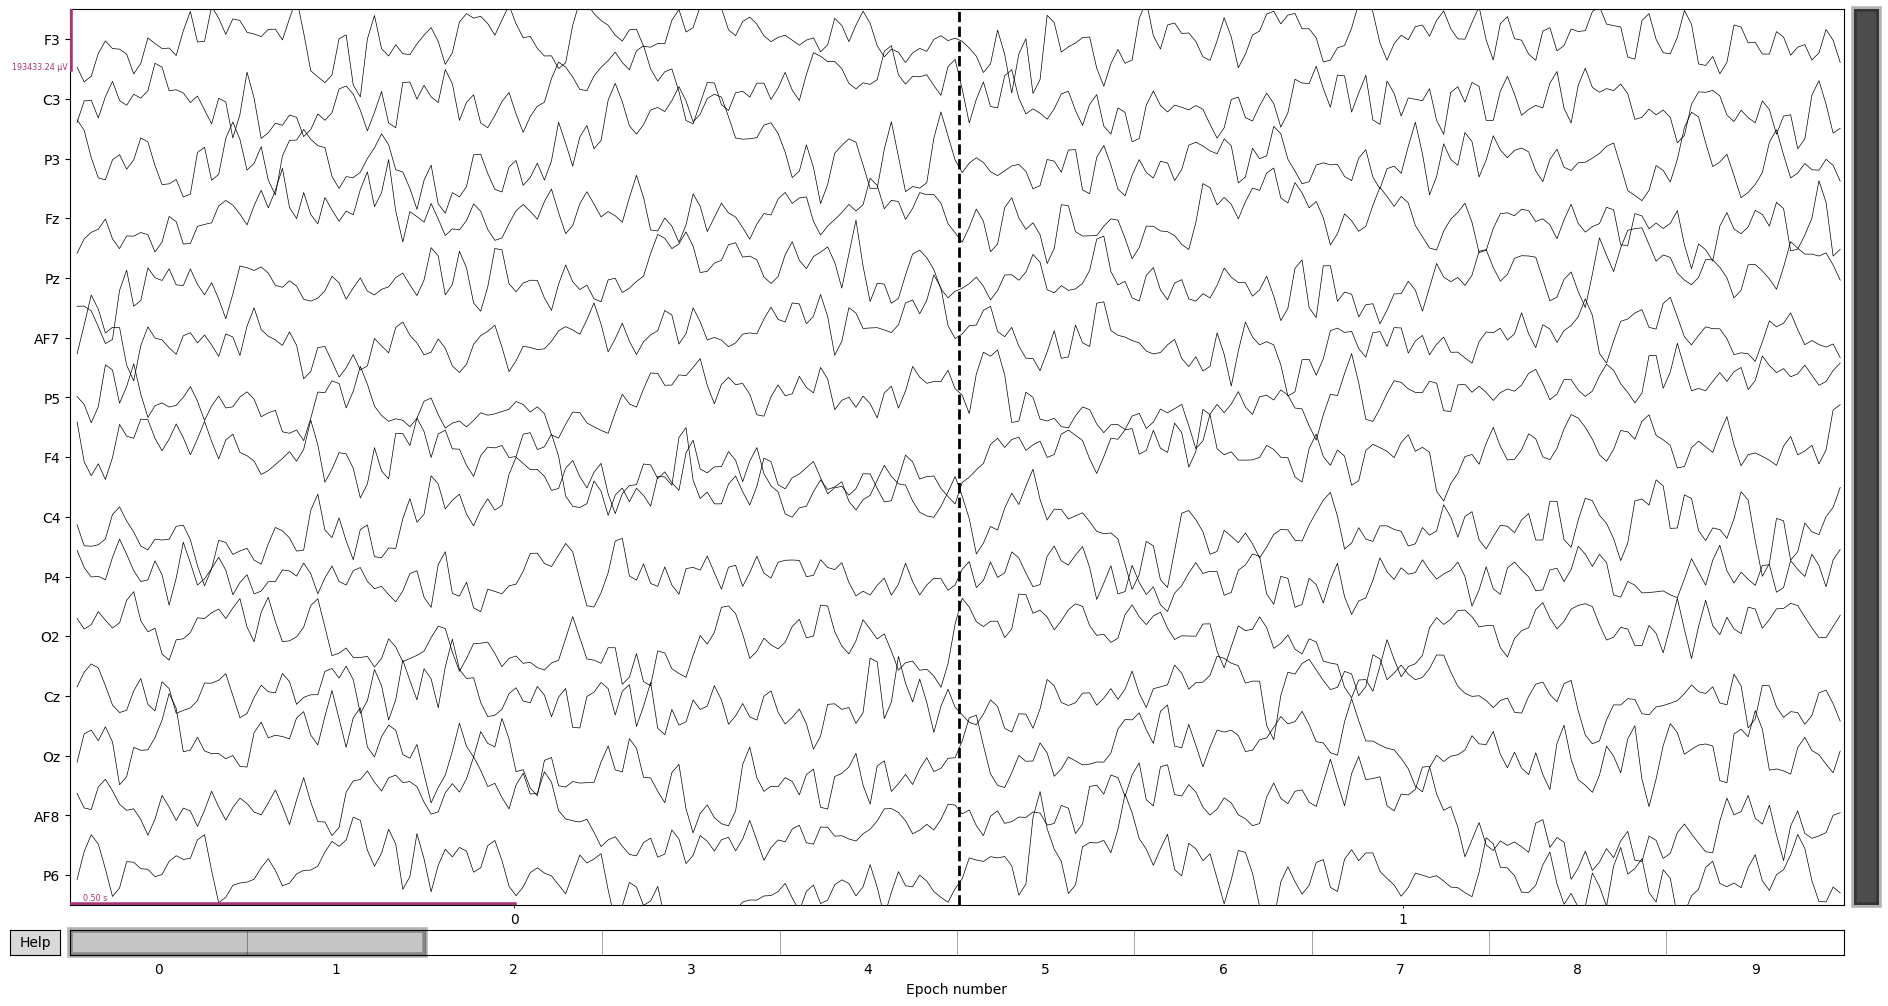

In [112]:
c.plot(n_epochs=2, n_channels=15, title="Epoch", scalings="auto", show=True, block=True)